# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 0. Clean Up the Zombie Processes
At the end of this notebook, when you execute `env.close()`, it does not clean up the environment completely. Instead, the Unity environment process becomes a "zombie" process. A zombie process is one that has completed execution but still has an entry in the process table because its parent process hasn’t properly reaped it.
You can yourself verify this by running these commands in the terminal. Find the parent process ID (PPID) of the zombie process:
```bash
ps -o pid,ppid,stat,cmd | grep Reacher
```
If the parent process (PPID) is not 1, kill it to clean up the zombie process:
```bash
kill -9 <PPID>
```
Below is the equivalent Python code that checks for and cleans zombie processes using `psutil`. **You need run the cell below only when you restart the Unity environment.** 

> **NOTE**: The code cell below will also kill the Kernel. You should restart it when required.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install .
!pip install torch
!pip install --upgrade typing_extensions


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# Select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# Select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Found path: /data/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/data/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/data/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The next cells load the environment, retrieve the brain, and print key information about the state and action spaces to confirm the environment is set up correctly.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# === Agent Definition and Supporting Components ===

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --- TUNED Hyperparameters ---
BUFFER_SIZE = int(1e6)  # replay buffer size (larger buffer)
BATCH_SIZE = 256        # minibatch size (larger batch)
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic (slightly smaller)
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""
     # --- LARGER Network ---
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""
   # --- LARGER Network ---
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    # ... (rest of the Agent class)
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

### 3. Define and Train the DDPG Agent

The following cells define all the components for the Deep Deterministic Policy Gradient (DDPG) agent and then execute the main training loop.


**・**The first cell contains the class definitions for the Actor, Critic, Agent, ReplayBuffer, and OUNoise.

**・**The second cell contains the primary training function, train_ddpg, which orchestrates the learning process over many episodes.


Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

Episode 100	Average Score: 21.17
Episode 125	Average Score: 30.19
Environment solved in 25 episodes!	Average Score: 30.19


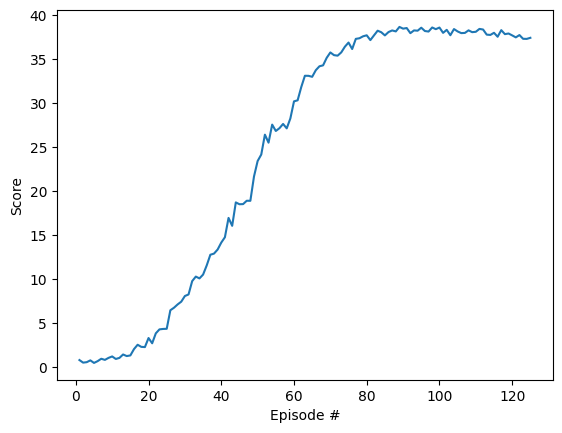

In [6]:
# === Main Training Loop ===

import matplotlib.pyplot as plt

# Instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=10)

def train_ddpg(n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    all_scores = []
    
    # Get the number of agents
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.memory.add(state, action, reward, next_state, done)

            if t % 20 == 0:
                if len(agent.memory) > BATCH_SIZE:
                    for _ in range(10):
                        experiences = agent.memory.sample()
                        agent.learn(experiences, GAMMA)

            states = next_states
            scores += rewards
            if np.any(dones):
                break 
                
        episode_score = np.mean(scores)
        scores_deque.append(episode_score)
        all_scores.append(episode_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return all_scores

# Start training
scores = train_ddpg()

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()